In [1]:
import numpy as np
import pandas as pd
from joblib import * 
from sklearn.metrics import r2_score,mean_absolute_error,mean_absolute_percentage_error,mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import geopandas as gpd
# from geopy.distance import distance,geodesic
from joblib import Parallel, delayed
import warnings
import matplotlib.pyplot as plt
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf,adfuller, kpss,range_unit_root_test
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import networkx as nx
from tqdm import tqdm
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

# different methods, all tested on 09-26 to 10-02

In [2]:
def masked_MAPE(v, v_, axis=None):
    '''
    Mean absolute percentage error.
    :param v: np.ndarray or int, ground truth.
    :param v_: np.ndarray or int, prediction.
    :param axis: axis to do calculation.
    :return: int, MAPE averages on all elements of input.
    '''
    mask = (v == 0)
    percentage = np.abs(v_ - v) / np.abs(v)
    if np.any(mask):
        masked_array = np.ma.masked_array(percentage, mask=mask)  # mask the dividing-zero as invalid
        result = masked_array.mean(axis=axis)
        if isinstance(result, np.ma.MaskedArray):
            return result.filled(np.nan)
        else:
            return result
    return np.mean(percentage, axis).astype(np.float64)

# station-level incoming/outgoing

In [ ]:
import joblib
joblib.dump(my_scaler, 'scaler.gz')
my_scaler = joblib.load('scaler.gz')

In [6]:
od = pd.read_csv('inoutwide2018.csv')
od = od.sort_values(by=['Date','Hour'])
od_test = pd.read_csv('inoutwide2019.csv')
## lag linear regression, many to one

# 48 continuous hourly lag, 3-7 days ago same hour-of-day lag, 7 weeks ago lag
for station in tqdm([i for i in od.columns if '_flow' in i]):
    subod = od[['Date','Hour',station,
 'dow-0','dow-1','dow-2','dow-3','dow-4','dow-5','dow-6',
 'hour-0','hour-1','hour-2','hour-3','hour-4','hour-5','hour-6','hour-7','hour-8','hour-9','hour-10',
 'hour-11','hour-12','hour-13','hour-14','hour-15','hour-16','hour-17','hour-18','hour-19','hour-20',
 'hour-21','hour-22','hour-23']]
    for lag in list(range(1,48))+list(np.array(list(range(3,8)))*24)+list(np.array(list(range(2,8)))*24*7):
        temp = subod[[station]].shift(lag)
        temp.columns = ['station'+'-lag-'+str(lag)]
        subod = pd.concat([subod,temp],axis=1)

    subod = subod.sort_values(by=['Date','Hour'])
    subod = subod.dropna()

    x = subod[[col for col in subod.columns if '-lag-' in col]]
    y = subod[[station]]

    scaler = StandardScaler()
    scaler.fit(x)
    x_train = scaler.transform(x)

    y_scaler = StandardScaler()
    y_scaler.fit(y)
    y_train = y_scaler.transform(y)

    model = LinearRegression(fit_intercept=False).fit(x_train, y_train)
    
    subod = od_test[['Date','Hour',station,
 'dow-0','dow-1','dow-2','dow-3','dow-4','dow-5','dow-6',
 'hour-0','hour-1','hour-2','hour-3','hour-4','hour-5','hour-6','hour-7','hour-8','hour-9','hour-10',
 'hour-11','hour-12','hour-13','hour-14','hour-15','hour-16','hour-17','hour-18','hour-19','hour-20',
 'hour-21','hour-22','hour-23']]
    for lag in list(range(1,48))+list(np.array(list(range(3,8)))*24)+list(np.array(list(range(2,8)))*24*7):
        temp = subod[[station]].shift(lag)
        temp.columns = ['station'+'-lag-'+str(lag)]
        subod = pd.concat([subod,temp],axis=1)

    subod = subod.sort_values(by=['Date','Hour'])
    subod = subod.dropna()

    x_test = subod[[col for col in subod.columns if '-lag-' in col]]
    y_test = subod[[station]]

#     print('out of sample R2')

    x_test = scaler.transform(x_test)
    y_pred = model.predict(x_test)
    y_pred = y_scaler.inverse_transform(y_pred)

    od_test[station+'_pred'] = y_pred

flow_columns = [i for i in od.columns if '_flow' in i]
y_test = od_test[flow_columns].values
y_pred = od_test[[i+'_pred' for i in flow_columns]].values
print(r2_score(y_test,y_pred))
print(mean_absolute_error(y_test,y_pred))
print(mean_squared_error(y_test,y_pred,squared=False))
print(np.mean(mean_squared_error(y_test,y_pred,multioutput='raw_values',squared=False)/np.std(y_test)))
print(masked_MAPE(y_test,y_pred))

  0%|                                                                                                     | 0/96 [00:00<?, ?it/s]


ValueError: Length of values (7584) does not match length of index (8760)

In [7]:
subod

,Date,Hour,incoming_flow-12TH,dow-0,dow-1,dow-2,dow-3,dow-4,dow-5,dow-6,hour-0,hour-1,hour-2,hour-3,hour-4,hour-5,hour-6,hour-7,hour-8,hour-9,hour-10,hour-11,hour-12,hour-13,hour-14,hour-15,hour-16,hour-17,hour-18,hour-19,hour-20,hour-21,hour-22,hour-23,station-lag-1,station-lag-2,station-lag-3,station-lag-4,station-lag-5,station-lag-6,station-lag-7,station-lag-8,station-lag-9,station-lag-10,station-lag-11,station-lag-12,station-lag-13,station-lag-14,station-lag-15,station-lag-16,station-lag-17,station-lag-18,station-lag-19,station-lag-20,station-lag-21,station-lag-22,station-lag-23,station-lag-24,station-lag-25,station-lag-26,station-lag-27,station-lag-28,station-lag-29,station-lag-30,station-lag-31,station-lag-32,station-lag-33,station-lag-34,station-lag-35,station-lag-36,station-lag-37,station-lag-38,station-lag-39,station-lag-40,station-lag-41,station-lag-42,station-lag-43,station-lag-44,station-lag-45,station-lag-46,station-lag-47,station-lag-72,station-lag-96,station-lag-120,station-lag-144,station-lag-168,station-lag-336,station-lag-504,station-lag-672,station-lag-840,station-lag-1008,station-lag-1176
1176,2019-02-19,0,23.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60.0,88.0,109.0,165.0,213.0,375.0,226.0,254.0,206.0,218.0,197.0,199.0,197.0,216.0,362.0,330.0,195.0,71.0,0.0,0.0,0.0,0.0,2.0,78.0,122.0,137.0,162.0,202.0,227.0,221.0,309.0,334.0,253.0,303.0,225.0,218.0,218.0,218.0,149.0,118.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,78.0,70.0,43.0,38.0,41.0,21.0,31.0,20.0,21.0,33.0,85.0
1177,2019-02-19,1,0.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23.0,60.0,88.0,109.0,165.0,213.0,375.0,226.0,254.0,206.0,218.0,197.0,199.0,197.0,216.0,362.0,330.0,195.0,71.0,0.0,0.0,0.0,0.0,2.0,78.0,122.0,137.0,162.0,202.0,227.0,221.0,309.0,334.0,253.0,303.0,225.0,218.0,218.0,218.0,149.0,118.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,226.0
1178,2019-02-19,2,0.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,23.0,60.0,88.0,109.0,165.0,213.0,375.0,226.0,254.0,206.0,218.0,197.0,199.0,197.0,216.0,362.0,330.0,195.0,71.0,0.0,0.0,0.0,0.0,2.0,78.0,122.0,137.0,162.0,202.0,227.0,221.0,309.0,334.0,253.0,303.0,225.0,218.0,218.0,218.0,149.0,118.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,115.0
1179,2019-02-19,3,0.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,23.0,60.0,88.0,109.0,165.0,213.0,375.0,226.0,254.0,206.0,218.0,197.0,199.0,197.0,216.0,362.0,330.0,195.0,71.0,0.0,0.0,0.0,0.0,2.0,78.0,122.0,137.0,162.0,202.0,227.0,221.0,309.0,334.0,253.0,303.0,225.0,218.0,218.0,218.0,149.0,118.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0
1180,2019-02-19,4,0.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,23.0,60.0,88.0,109.0,165.0,213.0,375.0,226.0,254.0,206.0,218.0,197.0,199.0,197.0,216.0,362.0,330.0,195.0,71.0,0.0,0.0,0.0,0.0,2.0,78.0,122.0,137.0,162.0,202.0,227.0,221.0,309.0,334.0,253.0,303.0,225.0,218.0,218.0,218.0,149.0,118.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,29.0,29.0,22.0,27.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2019-12-31,19,201.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,297.0,321.0,374.0,331.0,305.0,262.0,273.0,300.0,319.0,535.0,1138.0,990.0,496.0,130.0,0.0,0.0,0.0,1.0,75.0,61.0,105.0,109.0,132.0,238.0,387.0,566.0,420.0,334.0,246.0,247.0,291.0,284.0,376.0,828.0,1572.0,1264.0,568.0,180.0,0.0,0.0,0.0,0.0,38.0,72.0,73.0,100.0,110.0,196.0,198.0,173.0,74.0,98.0,496.0,496.0,582.0,413.0,527.0,512.0
8756,2019-12-31,20,173.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,201.0,297.0,321.0,374.0,331.0,305.0,262.0,273.0,300.0,319.0,535.

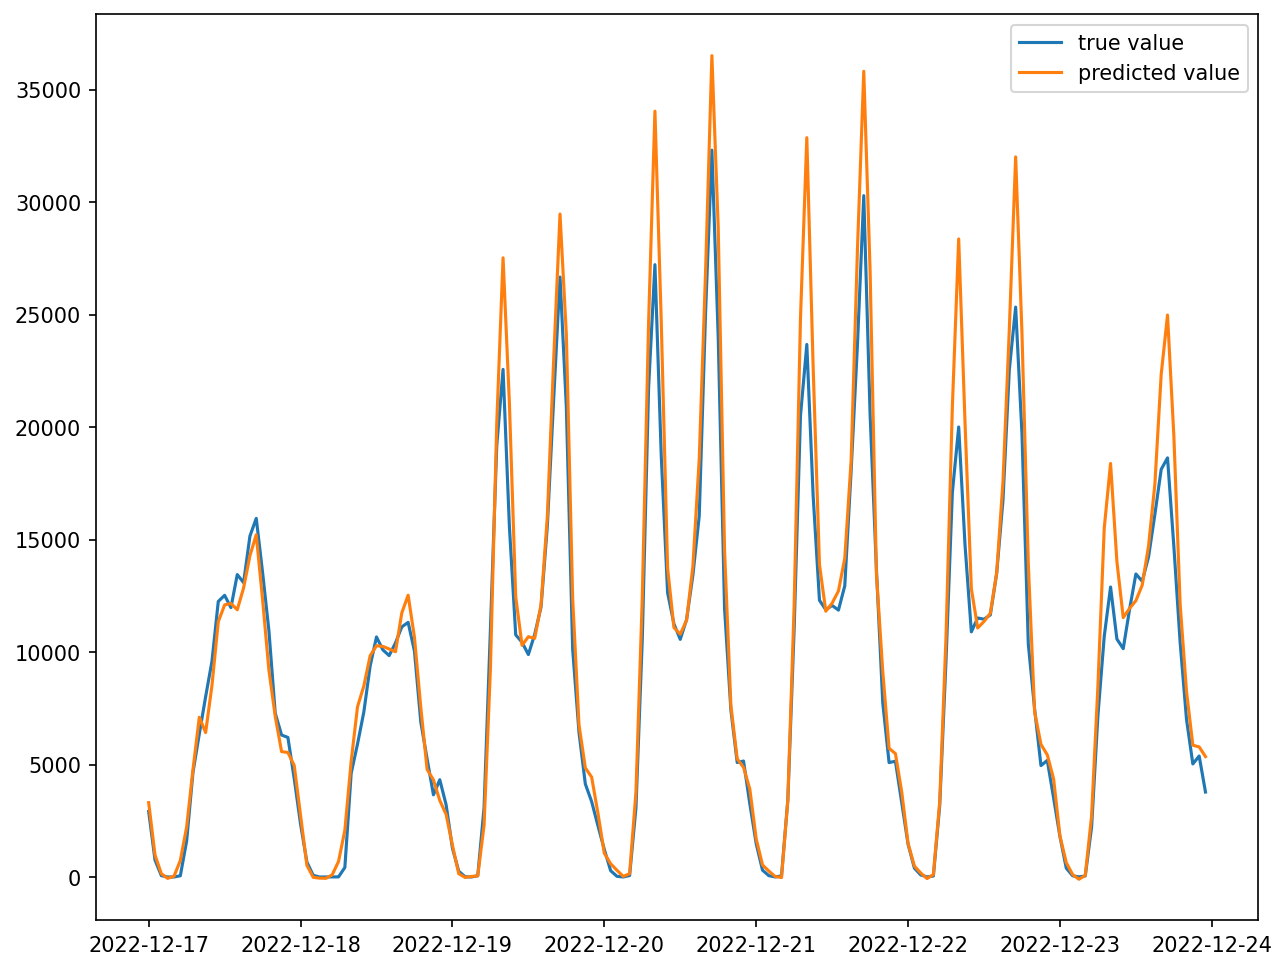

In [69]:
fig,ax = plt.subplots(dpi=150,figsize=(10,8))
plt.plot(pd.to_datetime(od_test['Date'] + ' ' + od_test['Hour'].astype('str') + ':00'),
         od_test[flow_columns].sum(axis=1),label='true value')
plt.plot(pd.to_datetime(od_test['Date'] + ' ' + od_test['Hour'].astype('str') + ':00'),
         od_test[[i+'_pred' for i in flow_columns]].sum(axis=1),label = 'predicted value')
# ax.set_xticks(ticks = plt.xticks, rotation=90)
plt.legend()

## adding  surrounding flows

In [96]:
# nearby stations incoming outgoing, separately
od = pd.read_csv('inoutwide.csv')
G = nx.read_gpickle('graph.pickle')
pbar = tqdm(list(G.nodes))
i = 0
for station in pbar:
    
    neightbor = list(nx.ego_graph(G, radius=1, n=station, distance='weight', center=False).nodes)
    flows = ['incoming_flow-'+i for i in [station]+neightbor]+\
              ['outgoing_flow-'+i for i in [station]+neightbor]
    subod = od[['Date','Hour']+['hour-'+str(i) for i in range(24)]+['dow-'+str(i) for i in range(7)]+flows]
    
    for lag in list(range(1,48))+list(np.array(list(range(3,8)))*24)+list(np.array(list(range(2,8)))*24*7):
        temp = subod[flows].shift(lag)
        temp.columns = [i+'-lag-'+str(lag) for i in flows]
        subod = pd.concat([subod,temp],axis=1)

    subod = subod.sort_values(by=['Date','Hour'])
    subod = subod.dropna()
    lags = [i for i in subod.columns if 'lag' in i]
    x = subod[lags+['hour-'+str(i) for i in range(24)]+['dow-'+str(i) for i in range(7)]]
    y = subod[['incoming_flow-'+station,'outgoing_flow-'+station]]

    # incoming model  training
    x_train = x.iloc[:268*24,:].values
    x_test = x.iloc[-24*8:,:].values
    y_train_in = y.iloc[:268*24,0].values.reshape(-1,1)
    y_train_out = y.iloc[:268*24,1].values.reshape(-1,1)
    y_test_in = y.iloc[-24*8:,0].values.reshape(-1,1)
    y_test_out = y.iloc[-24*8:,1].values.reshape(-1,1)

    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)
    
    y_in_scaler = StandardScaler()
    y_in_scaler.fit(y_train_in)
    y_train_in = y_in_scaler.transform(y_train_in)
    
    model_in = LinearRegression(fit_intercept=False).fit(x_train, y_train_in)
    
    y_pred_in_test = model_in.predict(x_test)
    y_pred_in_test = y_in_scaler.inverse_transform(y_pred_in_test)
    
    y_pred_in_train = model_in.predict(x_train)
    y_pred_in_train = y_in_scaler.inverse_transform(y_pred_in_train)
    
    in_trian_r2_score = r2_score(y_in_scaler.inverse_transform(y_train_in),y_pred_in_train)
    in_test_r2_score = r2_score(y_test_in,y_pred_in_test)
    # outgoing model training
    
    y_out_scaler = StandardScaler()
    y_out_scaler.fit(y_train_out)
    y_train_out = y_out_scaler.transform(y_train_out)

    model_out = LinearRegression(fit_intercept=False).fit(x_train, y_train_out)
    y_pred_out_test = model_out.predict(x_test)
    y_pred_out_test = y_out_scaler.inverse_transform(y_pred_out_test)
    
    y_pred_out_train = model_out.predict(x_train)
    y_pred_out_train = y_in_scaler.inverse_transform(y_pred_out_train)
    
    out_trian_r2_score = r2_score(y_in_scaler.inverse_transform(y_train_out),y_pred_out_train)
    out_test_r2_score = r2_score(y_test_out,y_pred_out_test)
    if i == 0: 
        y_true_test = y.iloc[-24*8:,:].values
        y_pred_test = np.concatenate([y_pred_in_test,y_pred_out_test],axis=1)
        
        y_true_train = y.iloc[:268*24,:].values
        y_pred_train = np.concatenate([y_pred_in_train,y_pred_out_train],axis=1)
    else:
        y_true_test = np.concatenate([y_true_test,y.iloc[-24*8:,:].values])
        y_pred_test = np.concatenate([y_pred_test,np.concatenate([y_pred_in_test,y_pred_out_test],axis=1)])
        
        y_true_train = np.concatenate([y_true_train,y.iloc[:268*24,:].values])
        y_pred_train = np.concatenate([y_pred_train,np.concatenate([y_pred_in_train,y_pred_out_train],axis=1)])
    i += 1
#     print(y_true_test.shape,y_pred_test.shape)
    pbar.set_description('incoming_train_R2:'+ str(round(in_trian_r2_score,4))+\
                        'incoming_test_R2:'+ str(round(in_test_r2_score,4))+\
                         'outgoing_train_R2:'+ str(round(out_trian_r2_score,4))+\
                        'outgoing_test_R2:'+ str(round(out_test_r2_score,4)))
#     break
    
print(r2_score(y_true_test,y_pred_test))
print(mean_absolute_error(y_true_test,y_pred_test))
print(mean_squared_error(y_true_test,y_pred_test,squared=False))
print(np.mean(mean_squared_error(y_true_test,y_pred_test,multioutput='raw_values',squared=False)/np.std(y_true_test)))
print(masked_MAPE(y_true_test,y_pred_test))    




incoming_train_R2:0.9359incoming_test_R2:0.6736outgoing_train_R2:0.9448outgoing_test_R2:-0.0611: 100%|█| 50/50 [01:05<00:00,  1.3

0.7450253708088482
22.358622620762468
50.65542239582835
0.48851728138469874
0.902141336690106


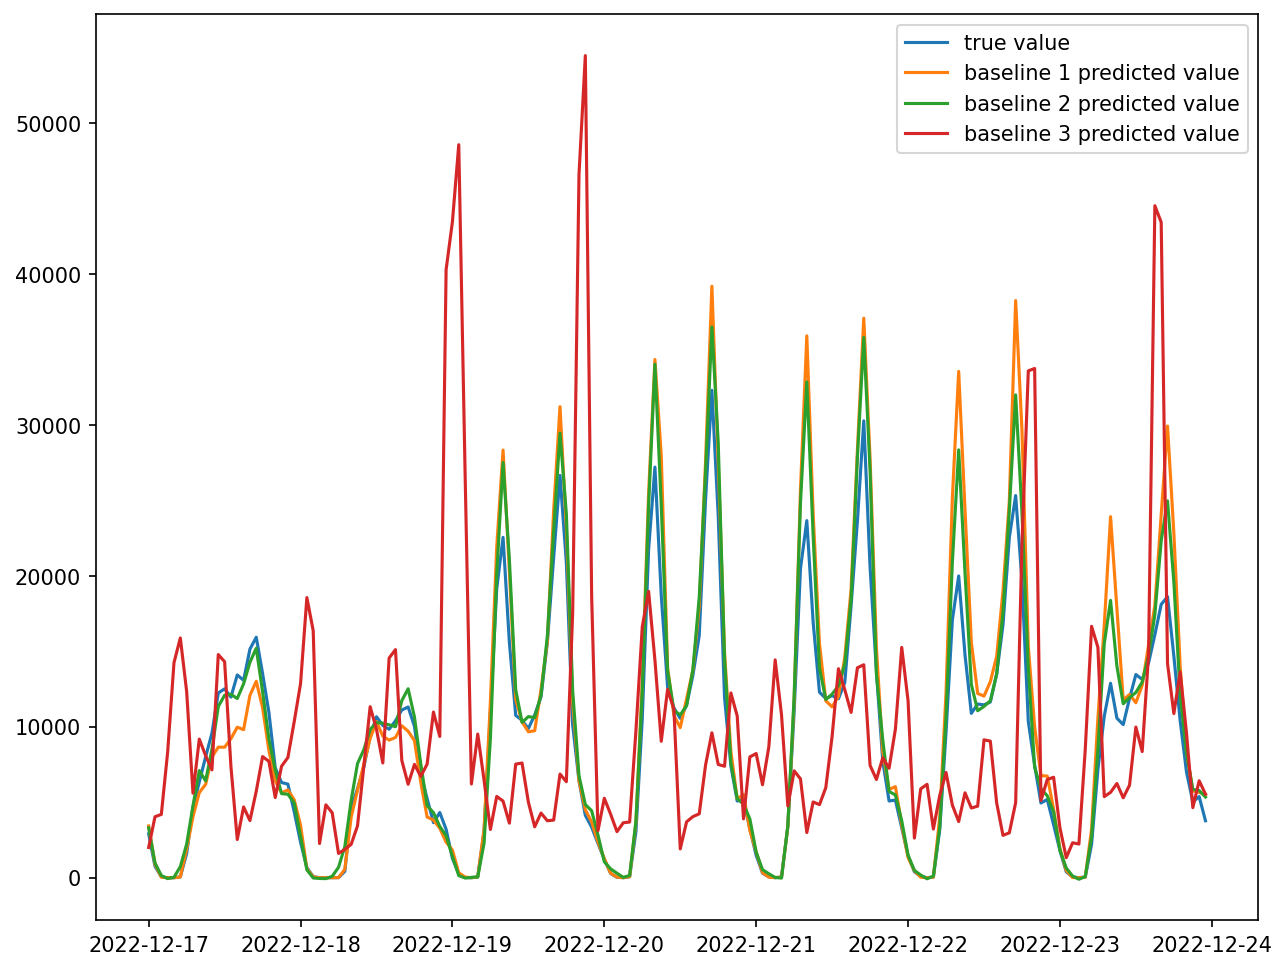

In [92]:
fig,ax = plt.subplots(dpi=150,figsize=(10,8))
plt.plot(pd.to_datetime(od_test['Date'] + ' ' + od_test['Hour'].astype('str') + ':00'),
         od_test[flow_columns].sum(axis=1),label='true value')
plt.plot(pd.to_datetime(od_test['Date'] + ' ' + od_test['Hour'].astype('str') + ':00'),
         od.iloc[-24*22:-24*15,:][flow_columns].sum(axis=1),label='baseline 1 predicted value')

plt.plot(pd.to_datetime(od_test['Date'] + ' ' + od_test['Hour'].astype('str') + ':00'),
         od_test[[i+'_pred' for i in flow_columns]].sum(axis=1),label = 'baseline 2 predicted value')
plt.plot(pd.to_datetime(od_test['Date'] + ' ' + od_test['Hour'].astype('str') + ':00'),
         y_pred_test.sum(axis=1).reshape(168,50).sum(axis=1),label = 'baseline 3 predicted value')
# ax.set_xticks(ticks = plt.xticks, rotation=90)
plt.legend()